### Edgar Moises Hernandez-Gonzalez
#### 29/04/20-16/10/20
#### Clasificacion binaria de imagenes motoras en EEG con CNN-2D
##### Caracteristicas = Espectrogramas STFT (3D)
##### Entrada de 990x31
##### 5 ejecuciones independientes

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.signal import spectrogram
from sklearn.metrics import (cohen_kappa_score, confusion_matrix,
                             roc_auc_score, roc_curve)
# from keras.utils import to_categorical
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

In [4]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [5]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/MI-EEG-ID-A09E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/Datos/Etiquetas-ID-A09E.csv", header=None)

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(144, 22000)
(144, 22000)
(144, 1)
(144, 1)


In [7]:
# en caso de no tener el y_test se puede utilizar el x_test
n_samples_train = len(y_train)
n_samples_test = len(y_test)

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 144
n_samples_test : 144


In [8]:
# esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test
n_classes = len(np.unique(y_test))

print("n_classes:", n_classes)

n_classes: 2


In [9]:
# las etiquetas en categorical para poder entrenar data augmentation
# y_train_categorical = to_categorical(y_train)
# y_test_categorical = to_categorical(y_test)

In [10]:
#unir 22 canales y resize de tamaño proporcional
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],990,31))
  temporal = np.zeros((990,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=500, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = Sxx[16:61, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [11]:
# probar log
def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],990,31))
  temporal = np.zeros((990,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=500, scaling='spectrum')
      temporal[j*45:(j+1)*45, :] = np.log(Sxx[16:61, :])
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
# probar resolucion de 0.5 Hz
'''def unir_espectrogramas_vertical(data):
  fs = 250
  datos = np.zeros((data.shape[0],1958,31))
  temporal = np.zeros((1958,31))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      #sig = sig[124:624]
      #espectrograma de STFFT
      f, t, Sxx = spectrogram(sig, fs=250, window='hann', nperseg=250,
                              noverlap=225, nfft=1000, scaling='spectrum')
      temporal[j*89:(j+1)*89, :] = Sxx[32:121, :]
    datos[i] = temporal
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos'''

In [12]:
#llamar a unir_espectrogramas_vertical(data)
inicio = time.time()

x_train = unir_espectrogramas_vertical(x_train)
x_test = unir_espectrogramas_vertical(x_test)

fin = time.time()
print("Tiempo:", fin - inicio)

0
100
0
100
Tiempo: 4.6932618618011475


In [13]:
print(x_train.shape)
print(x_test.shape)

(144, 990, 31)
(144, 990, 31)


In [14]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

5.689567374104006
5.848310324874562
-15.807022314581527
-16.928622214667644
-1.4201643295918536
-1.4706288131439245


In [15]:
x = np.ceil(np.max(x_train))

In [16]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= x
x_test /= x

In [17]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.94826126
0.9747184
-2.6345036
-2.821437
-0.23669396
-0.24510477


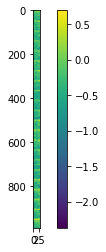

In [18]:
plt.figure()
plt.imshow(x_train[2])
plt.colorbar()
plt.show()

In [19]:
#convertir de 3D a 4D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

print(x_train.shape)
print(x_test.shape)

(144, 990, 31, 1)
(144, 990, 31, 1)


In [ ]:
# datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [ ]:
#mc = ModelCheckpoint('/content/drive/My Drive/BCI-IV-2a/Modelos/STFT_BI_09.hdf5',
#                     monitor='val_accuracy', save_best_only=True, verbose=0)

In [20]:
def CNN_2D():
  model = Sequential()
  model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool2D((2,2)))
  model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
  model.add(MaxPool2D((2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes, activation='softmax'))

  optimizer = Adam(lr=1e-4)
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])
  return model

Iteration: 1
loss:  0.29046207666397095
accuracy:  0.9097222089767456
kappa:  0.8194444444444444
confusion matrix:
 [[67  5]
 [ 8 64]]
AUC 0.9702932098765432


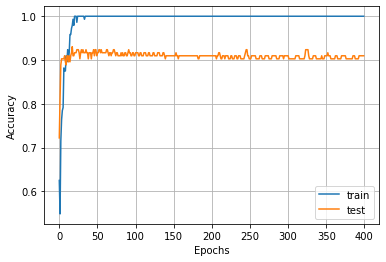

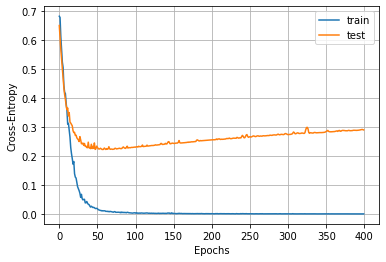

Iteration: 2
loss:  0.27870750427246094
accuracy:  0.9027777910232544
kappa:  0.8055555555555556
confusion matrix:
 [[66  6]
 [ 8 64]]
AUC 0.9731867283950617


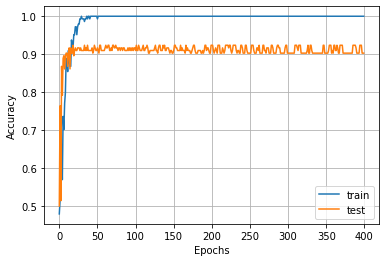

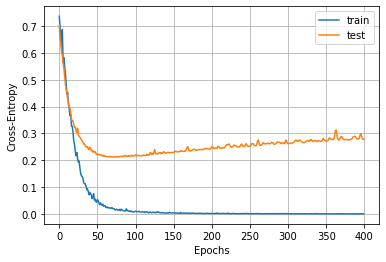

Iteration: 3
loss:  0.3184099793434143
accuracy:  0.9097222089767456
kappa:  0.8194444444444444
confusion matrix:
 [[66  6]
 [ 7 65]]
AUC 0.9704861111111112


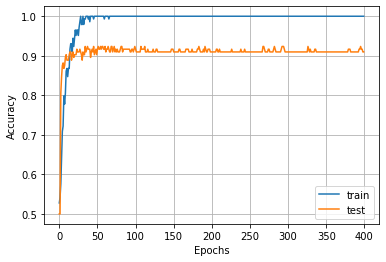

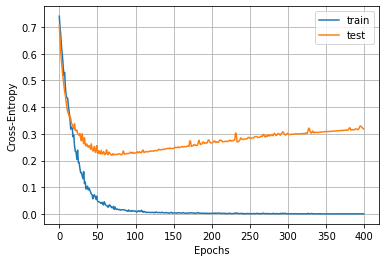

Iteration: 4
loss:  0.3255190849304199
accuracy:  0.9027777910232544
kappa:  0.8055555555555556
confusion matrix:
 [[66  6]
 [ 8 64]]
AUC 0.963155864197531


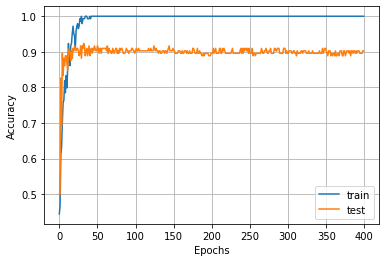

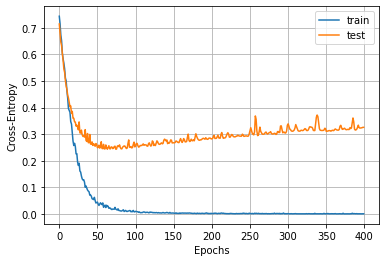

Iteration: 5
loss:  0.2855890393257141
accuracy:  0.9305555820465088
kappa:  0.8611111111111112
confusion matrix:
 [[69  3]
 [ 7 65]]
AUC 0.9760802469135803


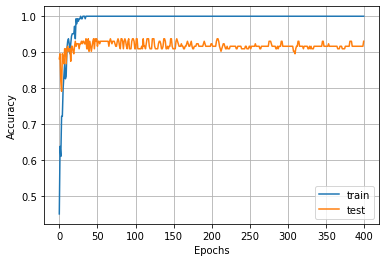

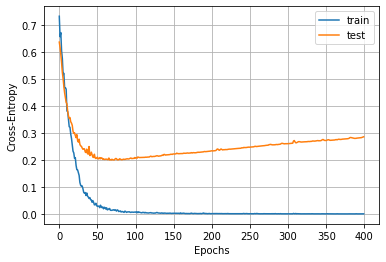


Resultados:
loss: [0.29046207666397095, 0.27870750427246094, 0.3184099793434143, 0.3255190849304199, 0.2855890393257141]
accuracy: [0.9097222089767456, 0.9027777910232544, 0.9097222089767456, 0.9027777910232544, 0.9305555820465088]
kappa: [0.8194444444444444, 0.8055555555555556, 0.8194444444444444, 0.8055555555555556, 0.8611111111111112]
AUC: [0.9702932098765432, 0.9731867283950617, 0.9704861111111112, 0.963155864197531, 0.9760802469135803]
Tiempo: 154.11614227294922


In [22]:
inicio = time.time()
array_loss = []
array_acc = []
array_kappa = []
array_auc = []
for i in range(5):
  print("Iteration:", i+1)
    
  model = CNN_2D()

  '''history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=36),
                                steps_per_epoch=np.ceil(n_samples_train/36),
                                epochs=1000,
                                validation_data=(x_test, y_test_categorical),
                                verbose=0)#, callbacks=[mc])

  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)'''

  history = model.fit(x_train, y_train, epochs=400, batch_size=36,
                      validation_data=(x_test, y_test), verbose=0)
                      #callbacks=[mc])
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)

  probabilidades = probabilidades[:, 1]
  auc = roc_auc_score(y_test, probabilidades)
  #fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
  array_auc.append(auc)

  print("AUC", auc)
  #plt.plot(fpr, tpr)
  #plt.grid()
  #plt.xlabel('False Positive Rate')
  #plt.ylabel('True Positive Rate')
  #plt.show()

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
print()
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)
print("AUC:", array_auc)
fin = time.time()
tiempo = fin - inicio
print("Tiempo:", tiempo)

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 990, 31, 16)       160       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 495, 15, 16)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 495, 15, 16)       2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 247, 7, 16)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 27664)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               3541120   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [24]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Mean AUC: %.4f" % np.mean(array_auc))
print("std: (+/- %.4f)" % np.std(array_auc))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))
print("Max AUC: %.4f" % np.max(array_auc))
print("Tiempo:", int(tiempo))

Mean Accuracy: 0.9111
std: (+/- 0.0102)
Mean Kappa: 0.8222
std: (+/- 0.0204)
Mean AUC: 0.9706
std: (+/- 0.0043)
Max Accuracy: 0.9306
Max Kappa: 0.8611
Max AUC: 0.9761
Tiempo: 154


In [25]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Oct 16 23:16:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    46W /  70W |   1637MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------